In [23]:
# IMDb Movie Review Sentiment Analysis

# ============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# ============================================================================

print("STEP 1: Importing Required Libraries")
print("'" * 40)

# Data manipulation libraries
import numpy as np  # Numerical operations
import pandas as pd  # Data handling

# Visualization libraries
import matplotlib.pyplot as plt  # Create plots
import seaborn as sns  # Statistical visualizations

# Machine learning libraries
from sklearn.model_selection import train_test_split  # Split data
from sklearn.feature_extraction.text import TfidfVectorizer  # Convert text to numbers
from sklearn.linear_model import LogisticRegression  # Linear model
from sklearn.naive_bayes import MultinomialNB  # Probabilistic model
from sklearn.ensemble import RandomForestClassifier  # Ensemble model

# Evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, auc, roc_auc_score)

# Text processing libraries
import re  # Pattern matching
import string  # String operations
from nltk.corpus import stopwords  # Common words removal
from nltk.stem import PorterStemmer  # Word normalization
import nltk  # Natural language toolkit
import time  # Track training time
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

print("." * 80)
print("IMDb MOVIE REVIEW SENTIMENT ANALYSIS")
print("Classification using Logistic Regression, Naive Bayes, and Random Forest")
print("." * 80)
print()

STEP 1: Importing Required Libraries
''''''''''''''''''''''''''''''''''''''''
................................................................................
IMDb MOVIE REVIEW SENTIMENT ANALYSIS
Classification using Logistic Regression, Naive Bayes, and Random Forest
................................................................................



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suyogsigdel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/suyogsigdel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
# ============================================================================
# STEP 2: LOAD DATASET
# ============================================================================

print("STEP 2: Loading IMDb Dataset")
print("'" * 40)

# Load IMDb dataset from Hugging Face
from datasets import load_dataset
dataset = load_dataset("imdb")

# Convert to pandas DataFrames
train_data = pd.DataFrame(dataset['train'])
test_data = pd.DataFrame(dataset['test'])

print()
print("Training samples:  ", len(train_data))
print("Testing samples:   ", len(test_data))
print("Features:          ", list(train_data.columns))
print()

STEP 2: Loading IMDb Dataset
''''''''''''''''''''''''''''''''''''''''

Training samples:   25000
Testing samples:    25000
Features:           ['text', 'label']



STEP 3: Dataset Exploration and Visualization
`````````````````````````````````````````````
Dataset Statistics:

Total reviews:             50000
Positive reviews (train):  12500
Negative reviews (train):  12500



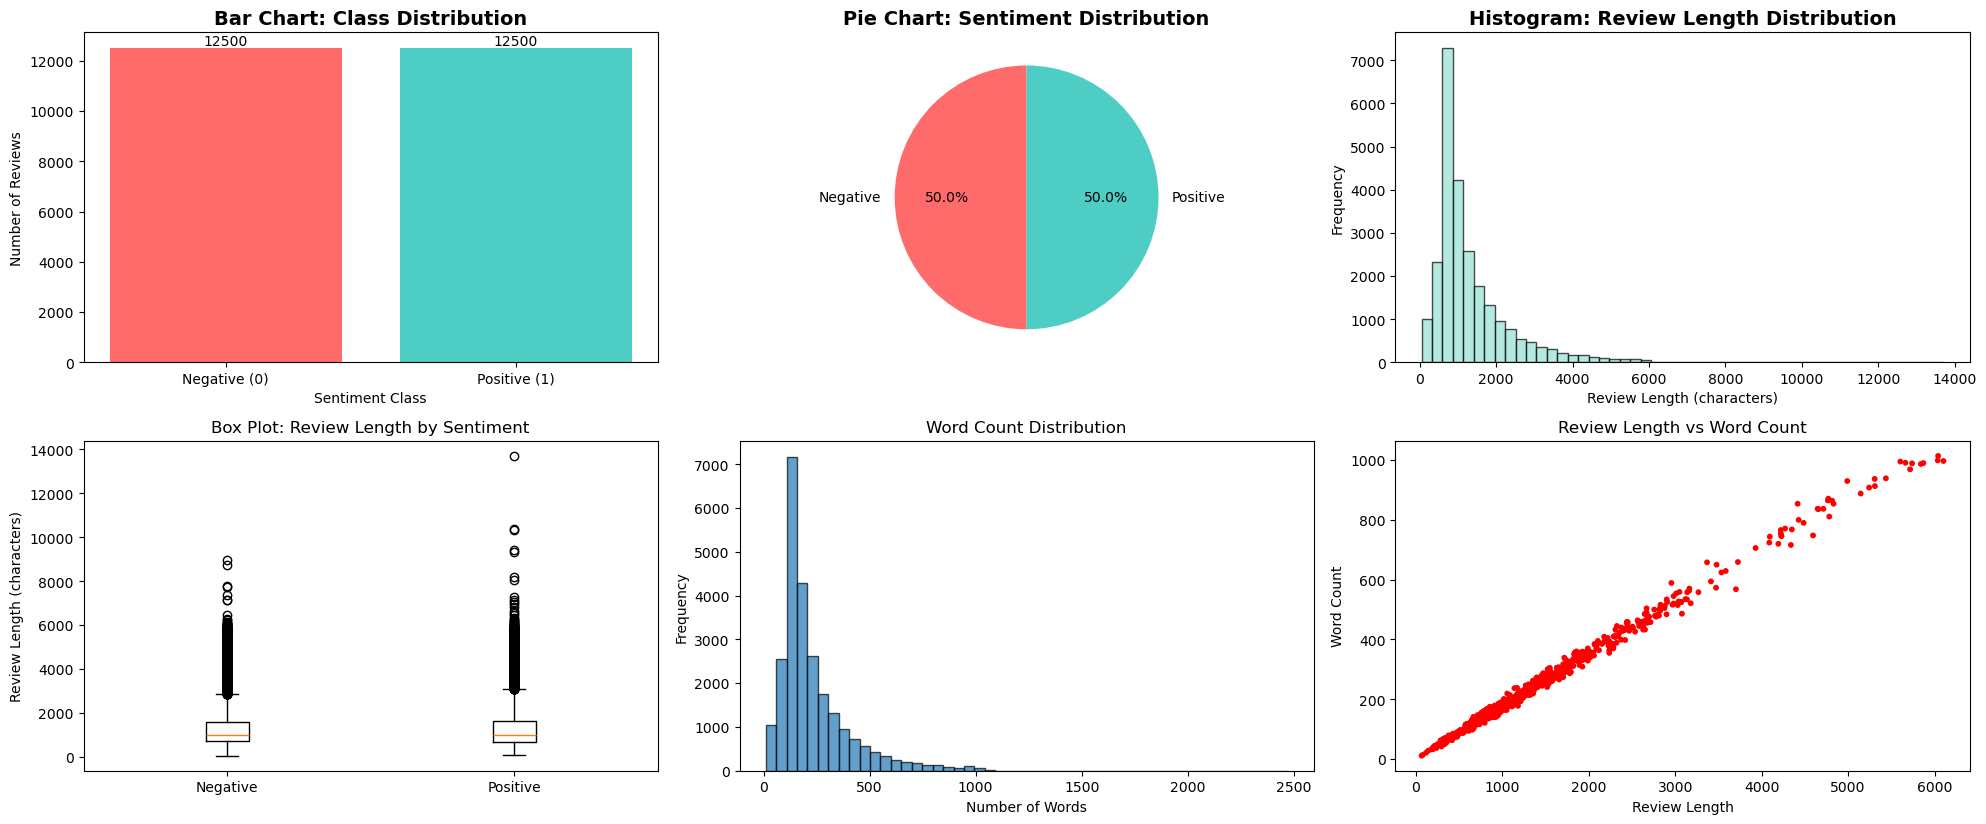

In [25]:




# ============================================================================
# STEP 3: DATA EXPLORATION AND VISUALIZATION
# ============================================================================

print("STEP 3: Dataset Exploration and Visualization")
print("`" * 45)

# Dataset statistics
print("Dataset Statistics:")
print()
print("Total reviews:            ", len(train_data) + len(test_data))
print("Positive reviews (train): ", sum(train_data['label'] == 1))
print("Negative reviews (train): ", sum(train_data['label'] == 0))
print()

# Calculate review lengths for analysis
train_data['review_length'] = train_data['text'].apply(len)
test_data['review_length'] = test_data['text'].apply(len)

# Create visualizations
fig = plt.figure(figsize=(20, 12))

# 1. Bar Chart - Class Distribution
plt.subplot(3, 3, 1)
class_counts = train_data['label'].value_counts()
plt.bar(['Negative (0)', 'Positive (1)'], class_counts.values, color=['#FF6B6B', '#4ECDC4'])
plt.title('Bar Chart: Class Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Number of Reviews')
plt.xlabel('Sentiment Class')
# Add value labels on bars
plt.text(0, class_counts.values[0], class_counts.values[0], ha='center', va='bottom') # value label for negative class
plt.text(1, class_counts.values[1], class_counts.values[1], ha='center', va='bottom') # value label for positive class

# 2. Pie Chart - Sentiment Distribution
plt.subplot(3, 3, 2)
plt.pie(class_counts.values, labels=['Negative', 'Positive'], 
        autopct='%1.1f%%', colors=['#FF6B6B', '#4ECDC4'], startangle=90) # autopct shows value of each slice
plt.title('Pie Chart: Sentiment Distribution', fontsize=14, fontweight='bold')

# 3. Histogram - Review Length Distribution
plt.subplot(3, 3, 3)
plt.hist(train_data['review_length'], bins=50, color='#95E1D3', edgecolor='black', alpha=0.7) # Bins show how many bars in histogram
plt.title('Histogram: Review Length Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')

# 4. Box Plot - Review Length by Sentiment
# 4. Box Plot - Review Length by Sentiment
plt.subplot(3, 3, 4)
data_for_box = [
    train_data[train_data['label'] == 0]['review_length'],
    train_data[train_data['label'] == 1]['review_length']
]
plt.boxplot(data_for_box, labels=['Negative', 'Positive'])
plt.title('Box Plot: Review Length by Sentiment')
plt.ylabel('Review Length (characters)')

# 5. Word Count Distribution
plt.subplot(3, 3, 5)
train_data['word_count'] = train_data['text'].apply(lambda x: len(x.split())) # Count words in each review and store in word_count
plt.hist(train_data['word_count'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Word Count Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# 6. Scatter Plot - Review Length vs Word Count
plt.subplot(3, 3, 6)

# Use red for Negative, blue for Positive
colors = ['red' if label == 0 else 'blue' for label in train_data['label']] # Goes through all data, if label is 0, color is red else blue if label is 1
plt.scatter(train_data['review_length'][:1000], train_data['word_count'][:1000], c=colors[:1000], s=10) # Plot only first 1000 points for clarity
# 1000 means taking only 1000 reviews
# s=10 means size of each dot in scatter plot

plt.title('Review Length vs Word Count')
plt.xlabel('Review Length')
plt.ylabel('Word Count')
plt.tight_layout() # Adjusts subplots so title and other texts don't overlap


# For saving the image
plt.savefig('dataset_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


print()


In [26]:
# ============================================================================
# STEP 4: TEXT PREPROCESSING
# ============================================================================
print("STEP 4: Text Preprocessing")
print("~" * 40)
print()

# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))  # Common words like "the", "is"
stemmer = PorterStemmer()  # Reduces words to root form

def preprocess_text(text):
    """
    Clean and prepare text for machine learning:
    1. Convert to lowercase
    2. Remove punctuation
    3. Remove numbers
    4. Tokenize (split text into individual words)
    5. Remove stopwords (common words like "the", "is")
    6. Stemming (reduce words to base form: "running" -> "run")
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove punctuation and numbers
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Tokenize: split into words
    tokens = text.split()
    
    # Remove stopwords and apply stemming
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) > 2]
    
    return ' '.join(tokens)


# Apply preprocessing to all reviews
train_data['cleaned_text'] = train_data['text'].apply(preprocess_text)
test_data['cleaned_text'] = test_data['text'].apply(preprocess_text)


print("Example of preprocessing:")
print("Original:", train_data['text'].iloc[0])
print()
print("Cleaned:", train_data['cleaned_text'].iloc[0])
print()

STEP 4: Text Preprocessing
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Example of preprocessing:
Original: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 ye

In [27]:

# ============================================================================
# STEP 5: FEATURE EXTRACTION (TF-IDF)
# ============================================================================

print("STEP 5: Feature Extraction using TF-IDF")
print("~" * 40)

# TF-IDF: Converts text to numbers based on word importance
# TF = Term Frequency (how often a word appears)
# IDF = Inverse Document Frequency (how unique a word is in that document)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Transform text to numerical features
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['cleaned_text'])

# Extract labels (0=negative, 1=positive)
y_train = train_data['label'].values
y_test = test_data['label'].values

print("Feature extraction completed!")
print()
print("Training features shape: ", X_train_tfidf.shape)
print("Testing features shape:  ", X_test_tfidf.shape)
print("Number of features:      ", len(tfidf_vectorizer.get_feature_names_out()))
print()

STEP 5: Feature Extraction using TF-IDF
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Feature extraction completed!

Training features shape:  (25000, 5000)
Testing features shape:   (25000, 5000)
Number of features:       5000



In [28]:
# ============================================================================
# STEP 6: MODEL TRAINING AND EVALUATION
# ============================================================================

print()
print("STEP 6: Training and Evaluating Models")
print("'" * 40)

# Store all model results
results = {}

# ============================================================================
# MODEL 1: LOGISTIC REGRESSION
# ============================================================================

print()
print("1. LOGISTIC REGRESSION")
print("~" * 55)

# Train the model
lr_start = time.time()
lr_model = LogisticRegression(max_iter=1000, random_state=42)  # random_state ensures reproducible results
lr_model.fit(X_train_tfidf, y_train)
lr_train_time = time.time() - lr_start

# Make predictions
lr_prediction = lr_model.predict(X_test_tfidf)
lr_prediction_probability = lr_model.predict_proba(X_test_tfidf)[:, 1]  # Probability scores

# Calculate performance metrics
lr_accuracy = accuracy_score(y_test, lr_prediction)
lr_precision = precision_score(y_test, lr_prediction)
lr_recall = recall_score(y_test, lr_prediction)
lr_f1 = f1_score(y_test, lr_prediction)
lr_cm = confusion_matrix(y_test, lr_prediction)

# Store results for comparison
results['Logistic Regression'] = {
    'model': lr_model,
    'predictions': lr_prediction,
    'prediction_probability': lr_prediction_probability,
    'accuracy': lr_accuracy,
    'precision': lr_precision,
    'recall': lr_recall,
    'f1_score': lr_f1,
    'confusion_matrix': lr_cm,
    'train_time': lr_train_time
}

print("Training completed in", round(lr_train_time, 2), "seconds")
print("Performance Metrics:")
print("  Accuracy:  ", round(lr_accuracy, 4))  # round to 4 decimal places for readability
print("  Precision: ", round(lr_precision, 4))
print("  Recall:    ", round(lr_recall, 4))
print("  F1-Score:  ", round(lr_f1, 4))

# ============================================================================
# MODEL 2: NAIVE BAYES
# ============================================================================

print()
print("2. NAIVE BAYES")
print("~" * 55)

# Train the model
nb_start = time.time()
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_train_time = time.time() - nb_start

# Make predictions
nb_prediction = nb_model.predict(X_test_tfidf)
nb_prediction_probability = nb_model.predict_proba(X_test_tfidf)[:, 1]  # Probability scores

# Calculate performance metrics
nb_accuracy = accuracy_score(y_test, nb_prediction)
nb_precision = precision_score(y_test, nb_prediction)
nb_recall = recall_score(y_test, nb_prediction)
nb_f1 = f1_score(y_test, nb_prediction)
nb_cm = confusion_matrix(y_test, nb_prediction)

# Store results for comparison
results['Naive Bayes'] = {
    'model': nb_model,
    'predictions': nb_prediction,
    'prediction_probability': nb_prediction_probability,
    'accuracy': nb_accuracy,
    'precision': nb_precision,
    'recall': nb_recall,
    'f1_score': nb_f1,
    'confusion_matrix': nb_cm,
    'train_time': nb_train_time
}

print("Training completed in", round(nb_train_time, 2), "seconds")
print("Performance Metrics:")
print("  Accuracy:  ", round(nb_accuracy, 4))  # round to 4 decimal places for readability
print("  Precision: ", round(nb_precision, 4))
print("  Recall:    ", round(nb_recall, 4))
print("  F1-Score:  ", round(nb_f1, 4))

# ============================================================================
# MODEL 3: RANDOM FOREST
# ============================================================================

print()
print("3. RANDOM FOREST")
print("~" * 55)

# Train the model
rf_start = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100,  # number of trees in the forest
    random_state=42,   # ensures reproducible results
    n_jobs=-1          # use all CPU cores for faster training
)
rf_model.fit(X_train_tfidf, y_train)
rf_train_time = time.time() - rf_start

# Make predictions
rf_prediction = rf_model.predict(X_test_tfidf)
rf_prediction_probability = rf_model.predict_proba(X_test_tfidf)[:, 1]  # Probability scores

# Calculate performance metrics
rf_accuracy = accuracy_score(y_test, rf_prediction)
rf_precision = precision_score(y_test, rf_prediction)
rf_recall = recall_score(y_test, rf_prediction)
rf_f1 = f1_score(y_test, rf_prediction)
rf_cm = confusion_matrix(y_test, rf_prediction)

# Store results for comparison
results['Random Forest'] = {
    'model': rf_model,
    'predictions': rf_prediction,
    'prediction_probability': rf_prediction_probability,
    'accuracy': rf_accuracy,
    'precision': rf_precision,
    'recall': rf_recall,
    'f1_score': rf_f1,
    'confusion_matrix': rf_cm,
    'train_time': rf_train_time
}

print("Training completed in", round(rf_train_time, 2), "seconds")
print("Performance Metrics:")
print("  Accuracy:  ", round(rf_accuracy, 4))  # round to 4 decimal places for readability
print("  Precision: ", round(rf_precision, 4))
print("  Recall:    ", round(rf_recall, 4))
print("  F1-Score:  ", round(rf_f1, 4))


STEP 6: Training and Evaluating Models
''''''''''''''''''''''''''''''''''''''''

1. LOGISTIC REGRESSION
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training completed in 0.08 seconds
Performance Metrics:
  Accuracy:   0.8779
  Precision:  0.8727
  Recall:     0.8848
  F1-Score:   0.8787

2. NAIVE BAYES
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training completed in 0.0 seconds
Performance Metrics:
  Accuracy:   0.8454
  Precision:  0.8462
  Recall:     0.8443
  F1-Score:   0.8453

3. RANDOM FOREST
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training completed in 3.19 seconds
Performance Metrics:
  Accuracy:   0.8433
  Precision:  0.8505
  Recall:     0.8331
  F1-Score:   0.8417



STEP 7: Model Comparison and Results Visualization

Model Performance Comparison:

              Model  Accuracy  Precision  Recall  F1-Score  Training Time (s)
Logistic Regression   0.87788   0.872722 0.88480  0.878719           0.076654
        Naive Bayes   0.84544   0.846216 0.84432  0.845267           0.004841
      Random Forest   0.84332   0.850470 0.83312  0.841705           3.188618

Best Model:   Logistic Regression
Accuracy:     0.8779



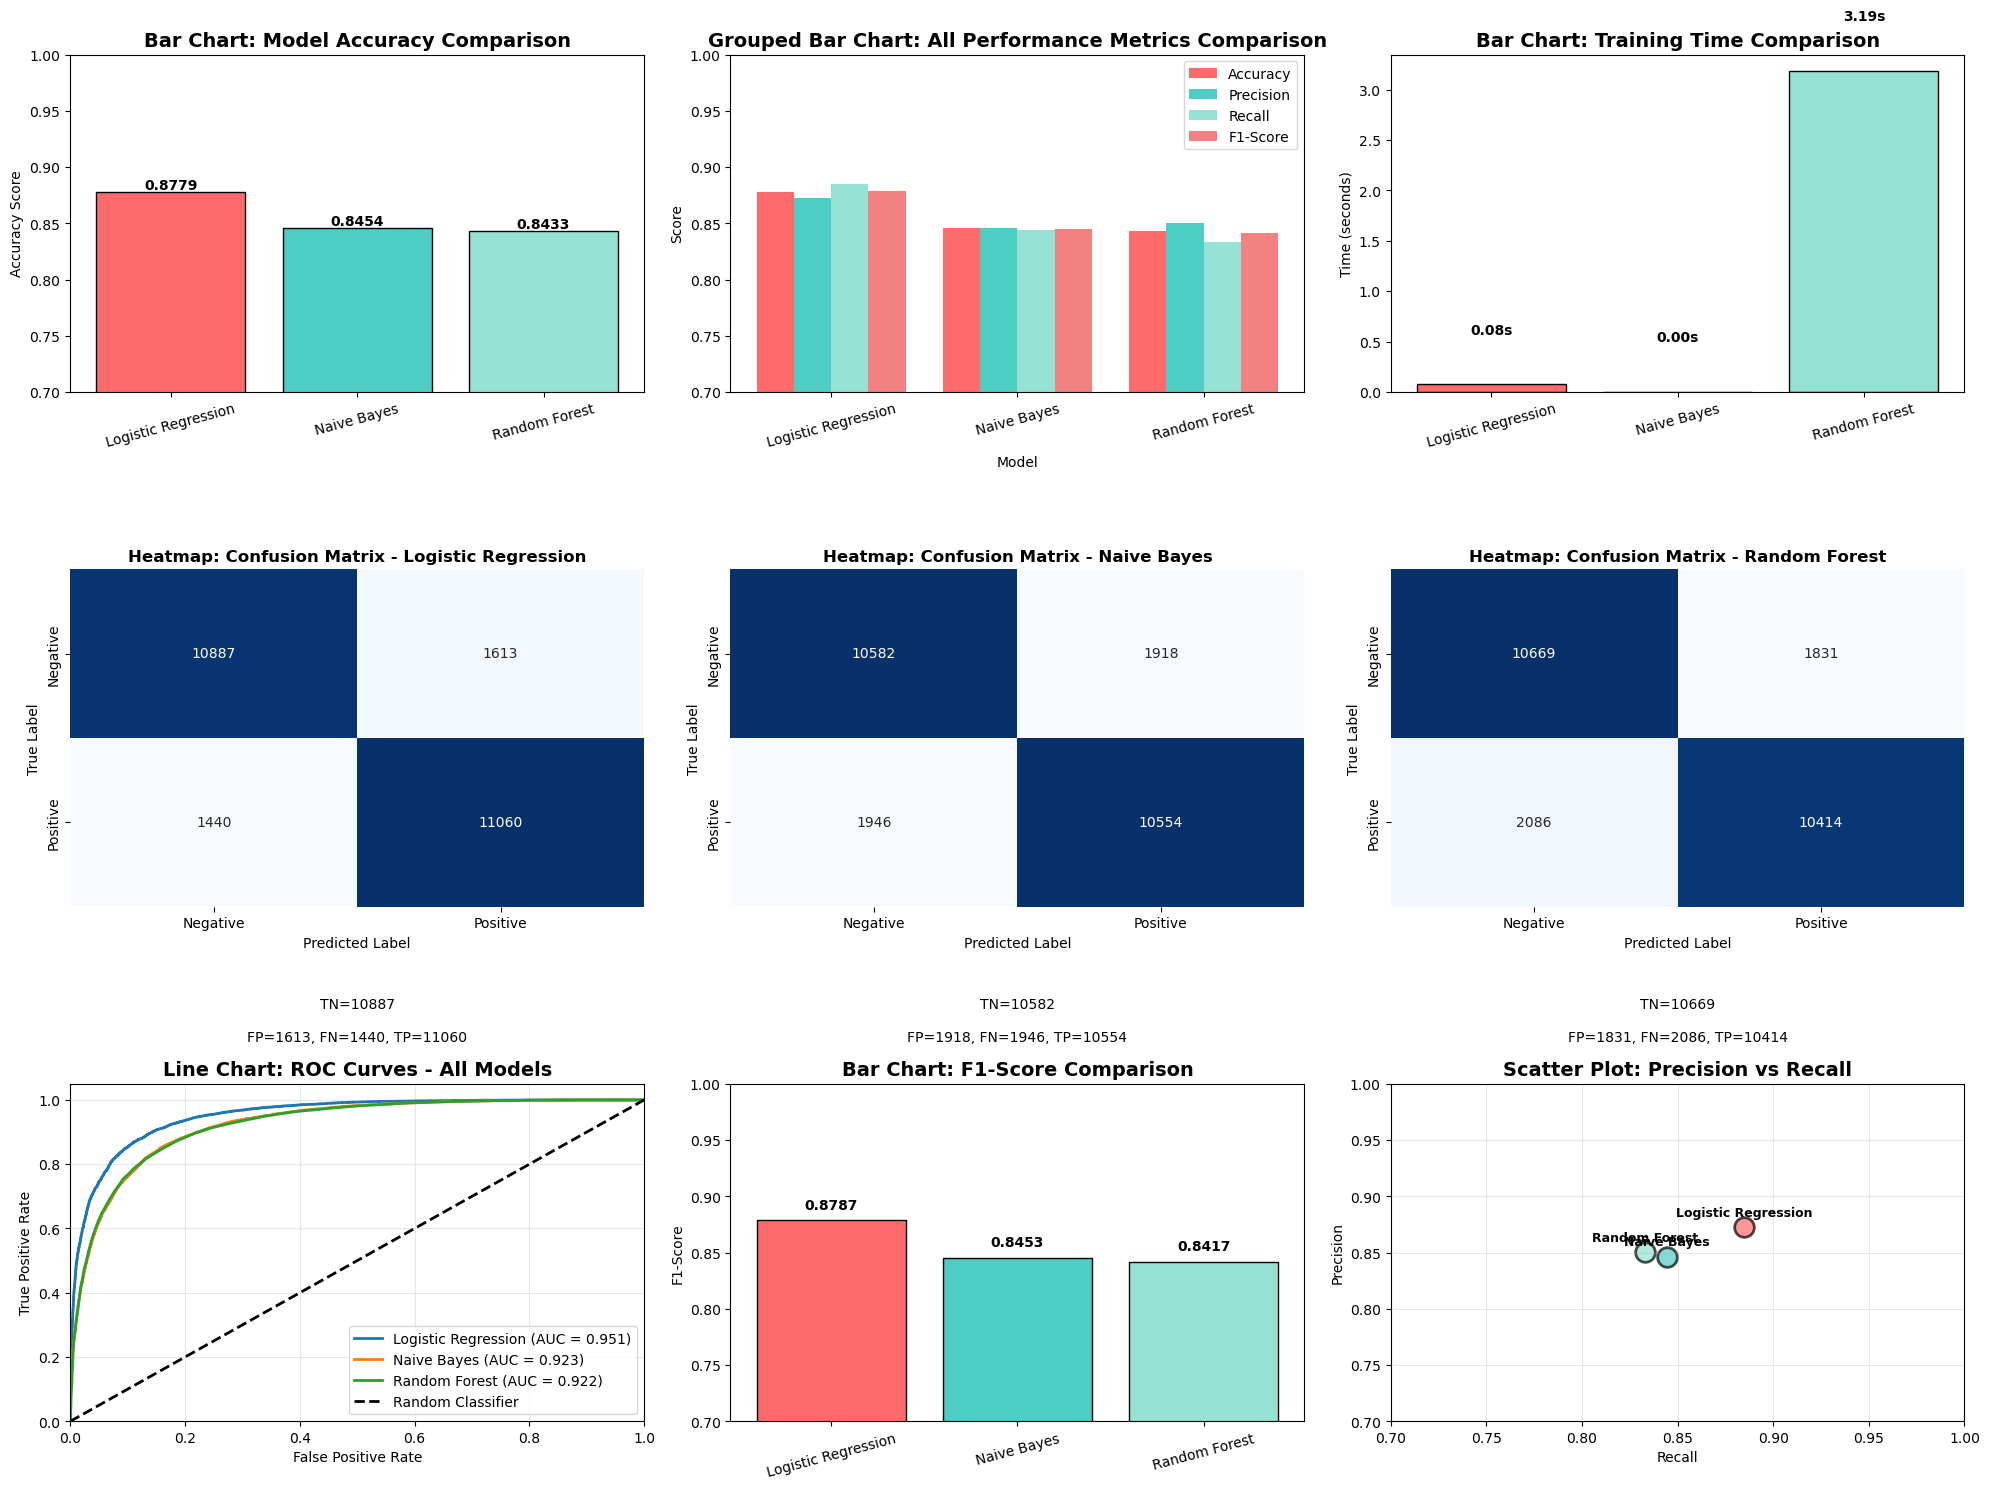

In [29]:
# ============================================================================
# STEP 7: RESULTS COMPARISON AND VISUALIZATION
# ============================================================================

print()
print("=" * 80)
print("STEP 7: Model Comparison and Results Visualization")
print("=" * 80)

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'Precision': [results[model]['precision'] for model in results],
    'Recall': [results[model]['recall'] for model in results],
    'F1-Score': [results[model]['f1_score'] for model in results],
    'Training Time (s)': [results[model]['train_time'] for model in results]
})

print()
print("Model Performance Comparison:")
print()
print(comparison_df.to_string(index=False))
print()

# Find best performing model
best_model_name = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']
best_accuracy = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Accuracy']
print("Best Model:  ", best_model_name)
print("Accuracy:    ", round(best_accuracy, 4))
print()

# ============================================================================
# DETAILED VISUALIZATIONS
# ============================================================================

fig = plt.figure(figsize=(20, 15))

# 1. Accuracy Comparison Bar Chart
plt.subplot(3, 3, 1)
colors_bar = ['#FF6B6B', '#4ECDC4', '#95E1D3']
bars = plt.bar(comparison_df['Model'], comparison_df['Accuracy'], color=colors_bar, edgecolor='black')
plt.title('Bar Chart: Model Accuracy Comparison', fontsize=14, fontweight='bold')  # Diagram type included
plt.ylabel('Accuracy Score')
plt.ylim([0.7, 1.0])
# Add value labels on bars
for i in range(len(bars)):
    height = bars[i].get_height()
    x_pos = bars[i].get_x() + bars[i].get_width() / 2.0
    plt.text(x_pos, height, f'{height:.4f}', ha='center', va='bottom', fontweight='bold')
plt.xticks(rotation=15)

# 2. All Metrics Comparison
plt.subplot(3, 3, 2)
x = np.arange(len(comparison_df['Model']))
width = 0.2
plt.bar(x - 1.5*width, comparison_df['Accuracy'], width, label='Accuracy', color='#FF6B6B')
plt.bar(x - 0.5*width, comparison_df['Precision'], width, label='Precision', color='#4ECDC4')
plt.bar(x + 0.5*width, comparison_df['Recall'], width, label='Recall', color='#95E1D3')
plt.bar(x + 1.5*width, comparison_df['F1-Score'], width, label='F1-Score', color='#F38181')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Grouped Bar Chart: All Performance Metrics Comparison', fontsize=14, fontweight='bold')  # Diagram type
plt.xticks(x, comparison_df['Model'], rotation=15)
plt.legend()
plt.ylim([0.7, 1.0])

# 3. Training Time Comparison
plt.subplot(3, 3, 3)
plt.bar(comparison_df['Model'], comparison_df['Training Time (s)'], color=colors_bar, edgecolor='black')
plt.title('Bar Chart: Training Time Comparison', fontsize=14, fontweight='bold')  # Diagram type
plt.ylabel('Time (seconds)')
plt.xticks(rotation=15)
# Add value labels on bars
for i in range(len(comparison_df)):
    time_val = comparison_df['Training Time (s)'].iloc[i]
    plt.text(i, time_val + 0.5, f'{time_val:.2f}s', ha='center', fontweight='bold')

# 4,5,6. Confusion Matrices
plot_position = 4
for model_name in results.keys():
    plt.subplot(3, 3, plot_position)
    cm = results[model_name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
               xticklabels=['Negative', 'Positive'],
               yticklabels=['Negative', 'Positive'])
    plt.title(f'Heatmap: Confusion Matrix - {model_name}', fontsize=12, fontweight='bold')  # Diagram type
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Adding TP, FP, TN, FN labels
    tn, fp, fn, tp = cm.ravel()
    plt.text(0.5, -0.3, f'TN={tn}', ha='center', transform=plt.gca().transAxes) # gca (get current axis) : returns the current axis
    plt.text(0.5, -0.4, f'FP={fp}, FN={fn}, TP={tp}', ha='center', transform=plt.gca().transAxes) # transAxes: position relative to the axes
    plot_position = plot_position + 1 # Increment position for next subplot

# 7. ROC Curves
plt.subplot(3, 3, 7)
for model_name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[model_name]['prediction_probability'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Line Chart: ROC Curves - All Models', fontsize=14, fontweight='bold')  # Diagram type
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# 8. F1-Score Comparison
plt.subplot(3, 3, 8)
plt.bar(comparison_df['Model'], comparison_df['F1-Score'], color=colors_bar, edgecolor='black')
plt.title('Bar Chart: F1-Score Comparison', fontsize=14, fontweight='bold')  # Diagram type
plt.ylabel('F1-Score')
plt.ylim([0.7, 1.0])
plt.xticks(rotation=15)
# Add value labels on bars
for i in range(len(comparison_df)):
    f1_val = comparison_df['F1-Score'].iloc[i]
    plt.text(i, f1_val + 0.01, f'{f1_val:.4f}', ha='center', fontweight='bold')

# 9. Precision vs Recall
plt.subplot(3, 3, 9)
for i in range(len(comparison_df)):
    recall_val = comparison_df['Recall'].iloc[i]
    precision_val = comparison_df['Precision'].iloc[i]
    model_name = comparison_df['Model'].iloc[i]
    
    plt.scatter(recall_val, precision_val, s=200, c=colors_bar[i], 
               edgecolors='black', linewidths=2, label=model_name, alpha=0.7)
    plt.text(recall_val, precision_val + 0.01, model_name, ha='center', fontsize=9, fontweight='bold')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Scatter Plot: Precision vs Recall', fontsize=14, fontweight='bold')  # Diagram type
plt.grid(alpha=0.3)
plt.xlim([0.7, 1.0])
plt.ylim([0.7, 1.0])

plt.tight_layout()
plt.savefig('model_evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()


In [30]:
# ============================================================================
# STEP 8: DETAILED CLASSIFICATION REPORTS
# ============================================================================

print("=" * 80)
print("STEP 8: DETAILED CLASSIFICATION REPORTS")
print("=" * 80)

for model_name in results.keys():
    print()
    print(model_name)
    print("-" * 80)
    print(classification_report(y_test, results[model_name]['predictions'], 
                               target_names=['Negative', 'Positive']))


STEP 8: DETAILED CLASSIFICATION REPORTS

Logistic Regression
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.88      0.87      0.88     12500
    Positive       0.87      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000


Naive Bayes
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.84      0.85      0.85     12500
    Positive       0.85      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000


Random Forest
--------------------------------------------------------------------------------
              

STEP 9 : FEATURE IMPORTANCE ANALYSIS (Random Forest)

Top 20 Most Important Features:

  bad                 : 0.018515
  worst               : 0.015677
  wast                : 0.014414
  great               : 0.010756
  aw                  : 0.010360
  love                : 0.008264
  bore                : 0.007559
  noth                : 0.006876
  stupid              : 0.006316
  best                : 0.006188
  excel               : 0.006112
  wors                : 0.006016
  terribl             : 0.005910
  beauti              : 0.005638
  horribl             : 0.005089
  poor                : 0.005048
  wast time           : 0.004955
  even                : 0.004441
  movi                : 0.004170
  minut               : 0.004134


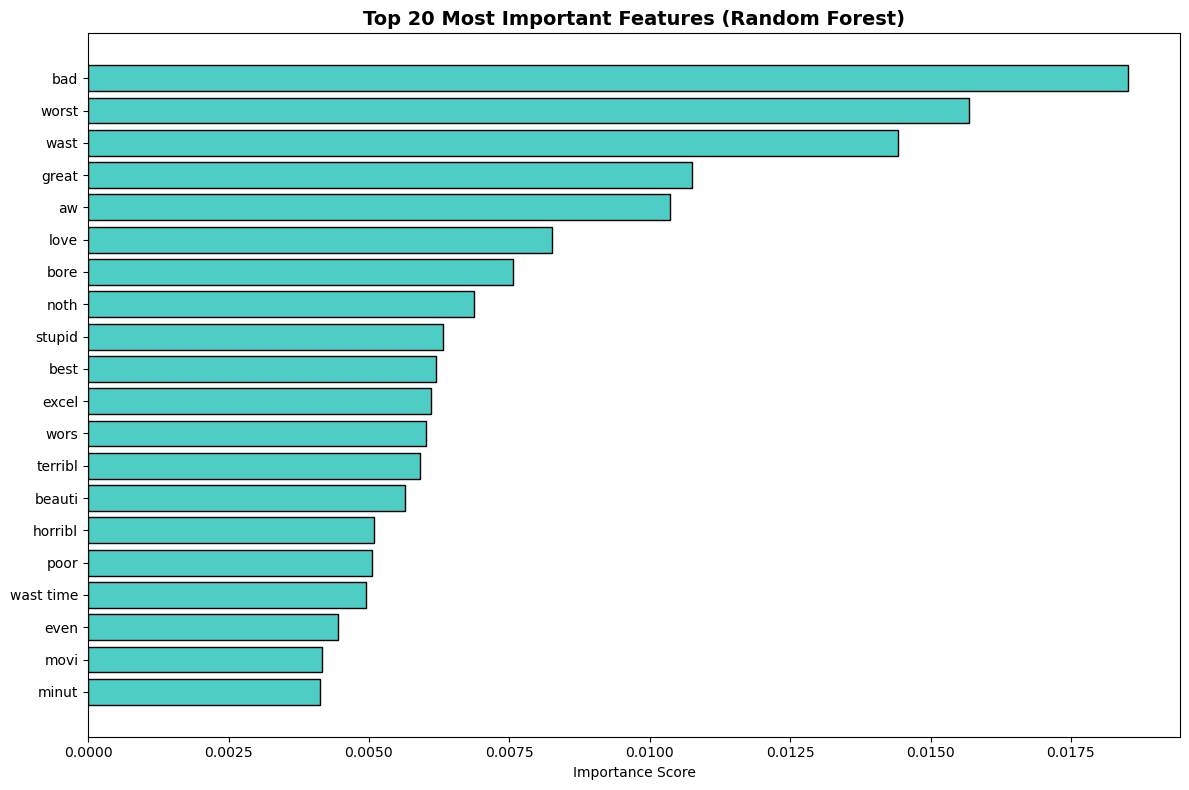

In [31]:

# ============================================================================
# STEP 9: FEATURE IMPORTANCE (RANDOM FOREST)
# ============================================================================

print("=" * 80)
print("STEP 9 : FEATURE IMPORTANCE ANALYSIS (Random Forest)")
print("=" * 80)

# Get feature names and their importance scores
feature_names = tfidf_vectorizer.get_feature_names_out()
importances = results['Random Forest']['model'].feature_importances_

# Get top 20 most important features
top_indices = np.argsort(importances)[-20:]
top_features = [feature_names[i] for i in top_indices]
top_importances = [importances[i] for i in top_indices]

print()
print("Top 20 Most Important Features:")
print()
# Print in reverse order (highest to lowest)
for i in range(len(top_features) - 1, -1, -1):
    print(f"  {top_features[i]:20s}: {top_importances[i]:.6f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_importances, color='#4ECDC4', edgecolor='black')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Importance Score')
plt.title('Top 20 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


In [47]:

# ============================================================================
# STEP 10: PREDICTION with Sample Data
# ============================================================================

print()
print("=" * 80)
print("STEP 10: Making Predictions on New Reviews")
print("=" * 80)

# Sample new reviews for testing
new_reviews = [
    "This movie is absolutely great. I loved every single minute of it.",
    "This movie was a terrible waste of time. This is the worst movie.",
    "The actors in this movie demonstrated great acting and the story had a good storyline.",
    "This movie is Boring. The ending was not what was expected, it was very bad."
]

print()
print("Predicting sentiment using the best model:", best_model_name)
print()

best_model = results[best_model_name]['model']

# Predict sentiment for each review
for i in range(len(new_reviews)):
    review = new_reviews[i]
    # Preprocess the review
    cleaned = preprocess_text(review)
    # Convert to TF-IDF features
    vectorized = tfidf_vectorizer.transform([cleaned])
    # Make prediction
    prediction = best_model.predict(vectorized)[0]
    probability = best_model.predict_proba(vectorized)[0]
    
    sentiment = "POSITIVE" if prediction == 1 else "NEGATIVE"
    confidence = probability[prediction] * 100
    
    print("Review", i + 1, ":")
    print("  Text:       ", review)
    print("  Sentiment:  ", sentiment)
    print("  Confidence: ", round(confidence, 2), "%")
    print()


STEP 10: Making Predictions on New Reviews

Predicting sentiment using the best model: Logistic Regression

Review 1 :
  Text:        This movie is absolutely great. I loved every single minute of it.
  Sentiment:   POSITIVE
  Confidence:  62.9 %

Review 2 :
  Text:        This movie was a terrible waste of time. This is the worst movie.
  Sentiment:   NEGATIVE
  Confidence:  99.98 %

Review 3 :
  Text:        The actors in this movie demonstrated great acting and the story had a good storyline.
  Sentiment:   POSITIVE
  Confidence:  67.06 %

Review 4 :
  Text:        This movie is Boring. The ending was not what was expected, it was very bad.
  Sentiment:   NEGATIVE
  Confidence:  98.39 %



In [33]:


# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("=" * 80)
print("FINAL SUMMARY")
print("=" * 80)
print()
print("Successfully trained and evaluated 3 machine learning models")
print("Dataset:                 ", f"{len(train_data) + len(test_data):,} IMDb movie reviews")
print("Best performing model:   ", best_model_name)
print("Best accuracy achieved:  ", round(max(comparison_df['Accuracy']), 4))
print()
print("All visualizations saved:")
print("   - dataset_visualization.png")
print("   - model_evaluation_results.png")
print("   - feature_importance.png")
print()
print("Project completed successfully!")
print("=" * 80)

FINAL SUMMARY

Successfully trained and evaluated 3 machine learning models
Dataset:                  50,000 IMDb movie reviews
Best performing model:    Logistic Regression
Best accuracy achieved:   0.8779

All visualizations saved:
   - dataset_visualization.png
   - model_evaluation_results.png
   - feature_importance.png

Project completed successfully!
